### Library 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_context('talk')
warnings.filterwarnings(action='ignore')

### 데이터 불러오기
> **target**
- 약 91%가 모두 0에 해당

In [2]:
train = pd.read_csv('./Data/application_train.csv')
test = pd.read_csv('./Data/application_test.csv')

In [3]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train.shape, test.shape

((307511, 122), (48744, 121))

In [5]:
_target = train['TARGET'].value_counts().reset_index()
_target.columns = ['target', 'counts']
_target['target_props'] = round(_target['counts'] / train.shape[0] * 100, 2)
_target

,target,counts,target_props
0,0,282686,91.93
1,1,24825,8.07


In [6]:
apps = pd.concat([train, test])
apps.shape

(356255, 122)

In [7]:
apps['TARGET'].value_counts(dropna=False)

0.0    282686
NaN     48744
1.0     24825
Name: TARGET, dtype: int64

In [8]:
object_columns = apps.dtypes[apps.dtypes == 'object'].index.tolist()

In [9]:
object_columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

### Label Encoding
- category형태의 컬럼을 모두 Label Encoding

In [10]:
for column in object_columns:
    apps[column] = pd.factorize(apps[column])[0]

### Null 값 제거

In [11]:
apps.isnull().sum()

SK_ID_CURR                        0
TARGET                        48744
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     47568
AMT_REQ_CREDIT_BUREAU_WEEK    47568
AMT_REQ_CREDIT_BUREAU_MON     47568
AMT_REQ_CREDIT_BUREAU_QRT     47568
AMT_REQ_CREDIT_BUREAU_YEAR    47568
Length: 122, dtype: int64

In [12]:
apps = apps.fillna(-999)

In [13]:
app_train = apps[apps['TARGET'] != -999]
app_test = apps[apps['TARGET']== -999]
app_train.shape, app_test.shape

((307511, 122), (48744, 122))

In [14]:
app_test = app_test.drop('TARGET', axis=1)

### 데이터셋 분리
- train_test_split을 활용해 train data와 val data로 분리

In [15]:
X = app_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
Y = app_train['TARGET']

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape, X_val.shape

((215257, 120), (92254, 120))

### LightGBM Classifier 사용
- 베이스라인 모델

In [17]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        eval_metric= 'auc',
        verbose= 100,
        early_stopping_rounds= 50)

[100]	training's auc: 0.752242	training's binary_logloss: 0.250332	valid_1's auc: 0.74086	valid_1's binary_logloss: 0.251859
[200]	training's auc: 0.771785	training's binary_logloss: 0.243601	valid_1's auc: 0.751803	valid_1's binary_logloss: 0.247818
[300]	training's auc: 0.785388	training's binary_logloss: 0.239356	valid_1's auc: 0.756039	valid_1's binary_logloss: 0.246381
[400]	training's auc: 0.79663	training's binary_logloss: 0.235888	valid_1's auc: 0.757637	valid_1's binary_logloss: 0.245833
[500]	training's auc: 0.806253	training's binary_logloss: 0.232966	valid_1's auc: 0.758238	valid_1's binary_logloss: 0.245608
[600]	training's auc: 0.814887	training's binary_logloss: 0.230286	valid_1's auc: 0.758583	valid_1's binary_logloss: 0.245486
[700]	training's auc: 0.822822	training's binary_logloss: 0.227764	valid_1's auc: 0.758947	valid_1's binary_logloss: 0.245364
[800]	training's auc: 0.830554	training's binary_logloss: 0.225244	valid_1's auc: 0.759005	valid_1's binary_logloss: 0.2

LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

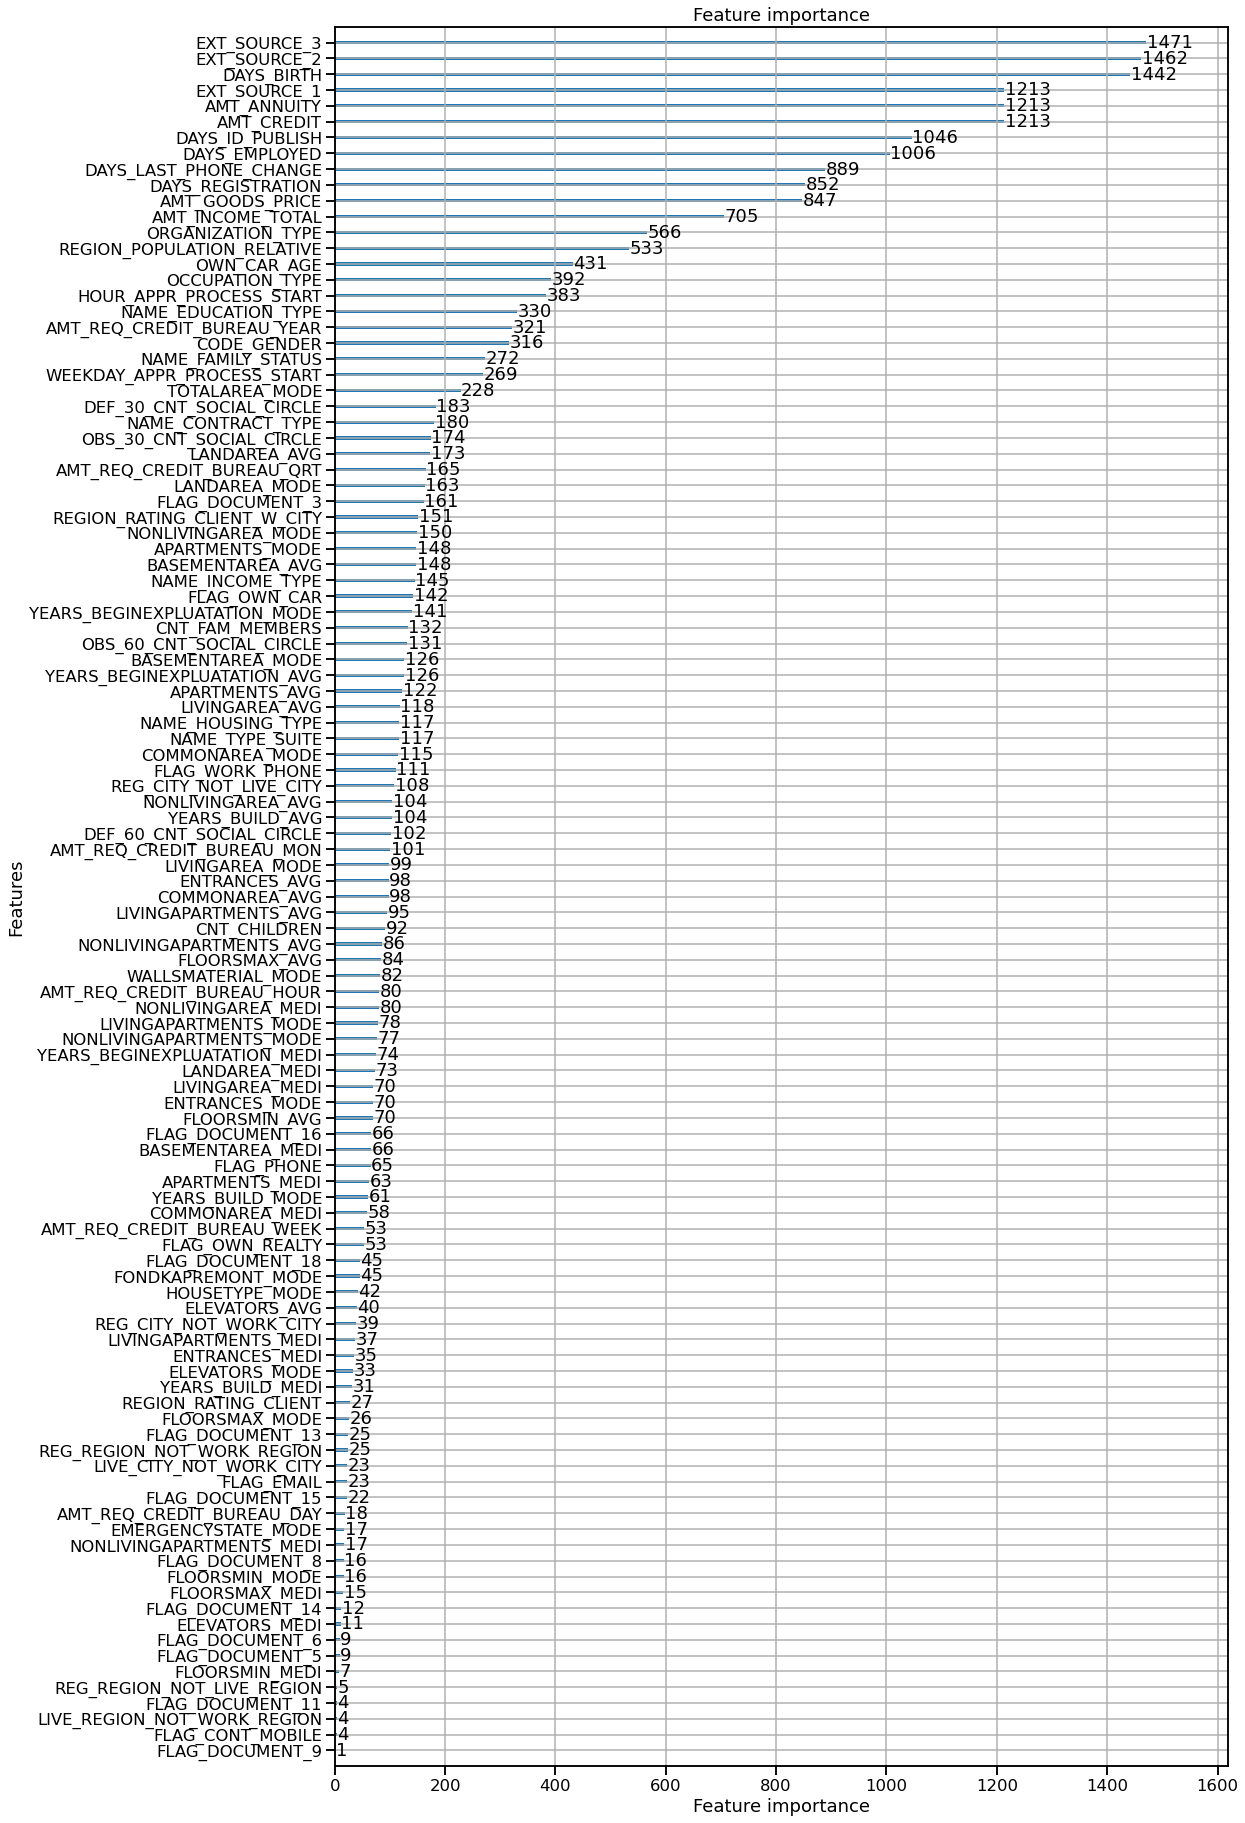

In [18]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

### 결과 제출

In [19]:
X_test = app_test.drop(['SK_ID_CURR'], axis=1)

In [20]:
app_test['TARGET'] = clf.predict_proba(X_test)[:, 1]

In [21]:
app_test[['SK_ID_CURR', 'TARGET']].to_csv('./result/01_baseline.csv', index=False)